In [23]:
import sys
import io
import time
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from keras.callbacks import LambdaCallback
from keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.utils import plot_model
import tensorflow as tf


# Fix for MacOS error:
# OMP: Error #15: Initializing libiomp5.dylib, but found libiomp5.dylib already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'



%matplotlib notebook

The main 'geoname' table has the following fields :
---------------------------------------------------
    geonameid         : integer id of record in geonames database
    name              : name of geographical point (utf8) varchar(200)
    asciiname         : name of geographical point in plain ascii characters, varchar(200)
    alternatenames    : alternatenames, comma separated, ascii names automatically transliterated, convenience attribute from alternatename table, varchar(10000)
    latitude          : latitude in decimal degrees (wgs84)
    longitude         : longitude in decimal degrees (wgs84)
    feature class     : see http://www.geonames.org/export/codes.html, char(1)
    feature code      : see http://www.geonames.org/export/codes.html, varchar(10)
    country code      : ISO-3166 2-letter country code, 2 characters
    cc2               : alternate country codes, comma separated, ISO-3166 2-letter country code, 200 characters
    admin1 code       : fipscode (subject to change to iso code), see exceptions below, see file admin1Codes.txt for display names of this code; varchar(20)
    admin2 code       : code for the second administrative division, a county in the US, see file admin2Codes.txt; varchar(80) 
    admin3 code       : code for third level administrative division, varchar(20)
    admin4 code       : code for fourth level administrative division, varchar(20)
    population        : bigint (8 byte int) 
    elevation         : in meters, integer
    dem               : digital elevation model, srtm3 or gtopo30, average elevation of 3''x3'' (ca 90mx90m) or 30''x30'' (ca 900mx900m) area in meters, integer. srtm processed by cgiar/ciat.
    timezone          : the iana timezone id (see file timeZone.txt) varchar(40)
    modification date : date of last modification in yyyy-MM-dd format

In [15]:
geoname_columns = ["geonameid", "name", "asciiname", "alternatenames", "latitude", "longitude", \
                   "feature_class", "feature_code", "country_code", "cc2", "admin1_code", "admin2_code", \
                   "admin3_code", "admin4_code", "population", "elevation", "dem", "timezone", "modification_date"]
raw_cities_data = pd.read_csv("data/cities500.txt", sep='\t', header=None, names=geoname_columns, index_col=0)
raw_cities_data

,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country_code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,elevation,dem,timezone,modification_date
geonameid,,,,,,,,,,,,,,,,,,
3038999,Soldeu,Soldeu,NaN,42.57688,1.66769,P,PPL,AD,NaN,02,NaN,NaN,NaN,602,NaN,1832,Europe/Andorra,2017-11-06
3039154,El Tarter,El Tarter,"Ehl Tarter,Эл Тартер",42.57952,1.65362,P,PPL,AD,NaN,02,NaN,NaN,NaN,1052,NaN,1721,Europe/Andorra,2012-11-03
3039163,Sant Julià de Lòria,Sant Julia de Loria,"San Julia,San Julià,Sant Julia de Loria,Sant J...",42.46372,1.49129,P,PPLA,AD,NaN,06,NaN,NaN,NaN,8022,NaN,921,Europe/Andorra,2013-11-23
3039604,Pas de la Casa,Pas de la Casa,"Pas de la Kasa,Пас де ла Каса",42.54277,1.73361,P,PPL,AD,NaN,03,NaN,NaN,NaN,2363,2050.0,2106,Europe/Andorra,2008-06-09
3039678,Ordino,Ordino,"Ordino,ao er di nuo,orudino jiao qu,Ордино,オルデ...",42.55623,1.53319,P,PPLA,AD,NaN,05,NaN,NaN,NaN,3066,NaN,1296,Europe/Andorra,2018-10-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895269,Beitbridge,Beitbridge,"Bajtbridz,Bajtbridzh,Beitbridge,Beitbridzas,Be...",-22.21667,30.00000,P,PPL,ZW,NaN,07,NaN,NaN,NaN,26459,NaN,461,Africa/Harare,2013-03-12
895308,Beatrice,Beatrice,Beatrice,-18.25283,30.84730,P,PPL,ZW,NaN,04,NaN,NaN,NaN,1647,NaN,1307,Africa/Harare,2018-05-09
895417,Banket,Banket,"Banket,Banket Junction",-17.38333,30.40000,P,PPL,ZW,NaN,05,NaN,NaN,NaN,9641,NaN,1277,Africa/Harare,2013-03-12


# Dataset Cleanup

In [16]:
def str_contains(string, test_chars):
    return any(char in test_chars for char in string)

# Remove names containing a character that occurs less than a minimum amount
def remove_least_common_chars(df, name_column, min_char_count=10):
    c = Counter(df[name_column].str.cat())
    total_char_counts = c.most_common()
    too_uncommon_chars = [c[0] for c in total_char_counts if c[1] < min_char_count]
    return df.drop(df.index[df[name_column].apply(lambda x: str_contains(x, too_uncommon_chars)).values]) # Remove remaining names that have a double quote in them


In [17]:
unwanted_columns = ["alternatenames", "feature_class", "feature_code", \
                    "cc2", "admin1_code", "admin2_code", "admin3_code", "admin4_code", \
                    "population", "elevation", "dem", "timezone", "modification_date"]
min_char_count = 1000
name_column = "name"

df = raw_cities_data.drop(columns=unwanted_columns)              

print("Cleaning up dataset, before starting we have:")
print(f'{len(df)} city names from {len(set(df["country_code"].values))} countries')

# Remove or replace bad stuff
df = df.dropna()
df[name_column] = df[name_column].str.lower() # Only lowercase for now
df[name_column] = df[name_column].str.replace(r"\(.*\)","") # Remove substrings within parenthesis
df[name_column] = df[name_column].str.replace(r"\[.*\]","") # Remove substrings within brackets
df[name_column] = df[name_column].str.replace(r'\".*\"',"") # Remove substrings within quotes
df[name_column] = df[name_column].str.replace(r"\'.*\'","") # Remove substrings within quotes
df = df.drop(df.index[df[name_column].str.contains('"').values]) # Remove remaining names that have a double quote in them
df[name_column] = df[name_column].map(lambda s: s.split("/")[0]) # If names has alt-name after slash, pick first
df[name_column] = df[name_column].str.strip() # Strip whitespace

df = remove_least_common_chars(df, name_column, min_char_count)


print(f'{len(df)} city names from {len(set(df["country_code"].values))} countries')
print("... is what we ended up with at the end.")

unique_chars = sorted(list(set(df[name_column].str.cat())))
print(f'{len(unique_chars)} unique characters')



Cleaning up dataset, before starting we have:
192528 city names from 246 countries
177802 city names from 244 countries
... is what we ended up with at the end.
40 unique characters


In [5]:
#unique_chars

# Data Exploration

In [18]:
from ipyleaflet import Map, Heatmap
m = Map(center=(0, 0), zoom=2)
locations = list(zip(df["latitude"].values, df["longitude"].values))
display(locations[:5])

heatmap = Heatmap(
    locations=locations,
    radius=10
)

m.add_layer(heatmap);

m

[(42.576879999999996, 1.6676900000000001),
 (42.57952, 1.65362),
 (42.542770000000004, 1.7336099999999999),
 (42.55623, 1.53319),
 (42.507290000000005, 1.53414)]

Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

# Dataset and Characters

In [19]:
NAME_BEGIN_CHAR = ">"
NAME_END_CHAR = "<"
LONGEST_NAME = df[name_column].str.len().max()
NAME_DIMENSION = LONGEST_NAME + 2 # Each name will be wrapper in begin/end characters

def pad_city_name(city_name):
    num_end_chars = 1 + LONGEST_NAME - len(city_name) # Pad all names with end char to have same length
    return NAME_BEGIN_CHAR + city_name + NAME_END_CHAR * num_end_chars


In [20]:
# Wrap all names in begin/end characters and pad them to same length
print(f"Longest city name was {LONGEST_NAME} characters, padding all names to match dimension.")
df["padded_name"] = df[name_column].map(pad_city_name)

# Create unqiue character list
CHARS = sorted(unique_chars + [NAME_BEGIN_CHAR, NAME_END_CHAR])
NUM_CHARS = len(CHARS)
print(f"Total number of unique characters including begin/end is {NUM_CHARS}")

# Create map for one-hot encoding of our characters
ONE_HOT_ENCODINGS = np_utils.to_categorical(range(NUM_CHARS))
ONE_HOT_MAP = {char : ONE_HOT_ENCODINGS[index] for index, char in enumerate(CHARS)}

Longest city name was 56 characters, padding all names to match dimension.
Total number of unique characters including begin/end is 42


In [21]:
def one_hot_to_char(one_hot_char):
    hot_index = np.where(one_hot_char == 1)[0][0]
    return CHARS[hot_index]

def sample_from_softmax(softmax_char, variability=0.5):
    logits = np.asarray(softmax_char).astype('float64')[0]
    if variability == 0:
        return np.argmax(logits)
    else:
        softmax_exp = np.exp(np.log(logits) / variability)
        distribution = np.random.multinomial(1, softmax_exp / np.sum(softmax_exp), 1)
        return np.argmax(distribution)
            
def single_softmax_to_one_hot(softmax_char, variability=0.5):
    hot_idx = sample_from_softmax(softmax_char, variability)
    return ONE_HOT_ENCODINGS[hot_idx]

def single_softmax_to_char(softmax_char, variability=0.5):
    hot_idx = sample_from_softmax(softmax_char, variability)
    return CHARS[hot_idx]

def softmax_to_one_hot_name(softmax_array):
    return [single_softmax_to_one_hot(sm) for sm in softmax_array]

# Model Architecture

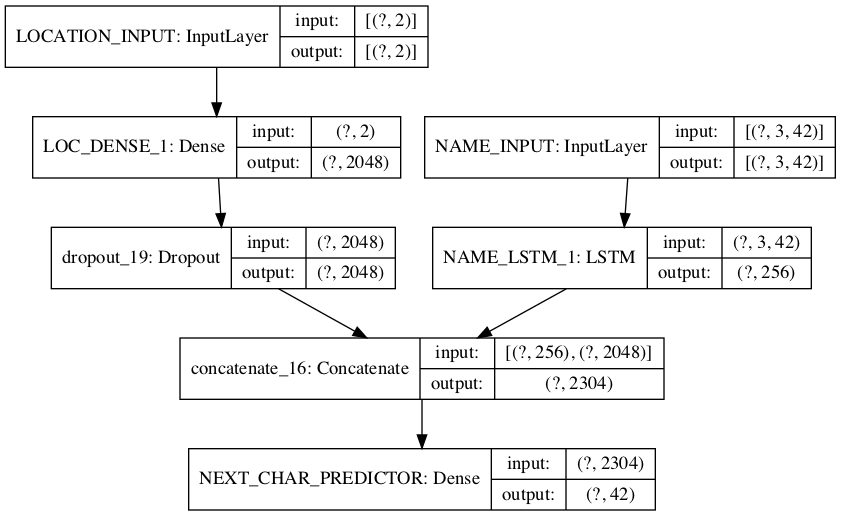

In [223]:
# Functional API, multiple inputs
NAME_INPUT_NAME = "NAME_INPUT"
LOCATION_INPUT_NAME = "LOCATION_INPUT"
NEXT_CHAR_OUTPUT_NAME = "NEXT_CHAR_PREDICTOR"

MODEL_MEMORY = 3
LOCATION_DIM = 2

NAME_LSTM_1_UNITS = 256
NAME_LSTM_1_ACTIVATION = 'relu'
NAME_LSTM_1_DROPOUT = 0.2

NAME_LSTM_2_UNITS = 256
NAME_LSTM_2_ACTIVATION = 'relu'
NAME_LSTM_2_DROPOUT = 0.25

NAME_DENSE_1_SIZE = NUM_CHARS
NAME_DENSE_1_ACTIVATION = 'softmax'
NAME_DENSE_1_DROPOUT = 0

LOC_DENSE_1_SIZE = 2048
LOC_DENSE_1_ACTIVATION = 'relu'
LOC_DENSE_1_DROPOUT = 0.3

LOC_DENSE_2_SIZE = 128
LOC_DENSE_2_ACTIVATION = 'relu'
LOC_DENSE_2_DROPOUT = 0.1

X_DENSE_1_SIZE = 64
X_DENSE_1_ACTIVATION = 'relu'

OUTPUT_DENSE_ACTIVATION = 'softmax'


# Input layers:
name_input_shape = (MODEL_MEMORY, NUM_CHARS)
location_input_shape = (LOCATION_DIM,)


name_input = tf.keras.Input(shape=name_input_shape, name=NAME_INPUT_NAME)
location_input = tf.keras.Input(shape=location_input_shape, name=LOCATION_INPUT_NAME)


name_features = LSTM(NAME_LSTM_1_UNITS,
                     input_shape=name_input_shape,
                     return_sequences=False,
                     return_state=False,
                     activation=NAME_LSTM_1_ACTIVATION,
                     dropout=NAME_LSTM_1_DROPOUT,
                     name="NAME_LSTM_1")(name_input)

#name_features = LSTM(NAME_LSTM_2_UNITS,
#                     input_shape=name_input_shape,
#                     return_sequences=False,
#                     return_state=False,
#                     activation=NAME_LSTM_2_ACTIVATION,
#                     dropout=NAME_LSTM_2_DROPOUT,
#                     name="NAME_LSTM_2")(name_features)


#name_features = tf.keras.backend.concatenate(name_features)

#name_features = Dense(NAME_DENSE_1_SIZE,
                      #activation=NAME_DENSE_1_ACTIVATION)(name_features)

#name_features = Dropout(NAME_DENSE_1_DROPOUT)(name_features)



location_features = Dense(LOC_DENSE_1_SIZE,
                          activation=LOC_DENSE_1_ACTIVATION, name="LOC_DENSE_1")(location_input)

location_features = Dropout(LOC_DENSE_1_DROPOUT)(location_features)

#location_features = Dense(LOC_DENSE_2_SIZE,
#                          activation=LOC_DENSE_2_ACTIVATION, name="LOC_DENSE_2")(location_features)

#location_features = Dropout(LOC_DENSE_2_DROPOUT)(location_features)


x = layers.concatenate([name_features, location_features])
#x = Dense(X_DENSE_1_SIZE, activation=X_DENSE_1_ACTIVATION, name="X_DENSE_1")(x)

next_char_pred = Dense(NUM_CHARS, activation=OUTPUT_DENSE_ACTIVATION, name=NEXT_CHAR_OUTPUT_NAME)(x)

model = tf.keras.Model(
    inputs=[name_input, location_input],
    outputs=[next_char_pred],
)

plot_model(model, show_shapes=True)

## Training Parameters and Data

In [225]:
def row_to_normalized_cartesian_coords(row):
    coords = to_normalized_cartesian_coords(row["latitude"], row["longitude"])
    row["x"] = coords[0]
    row["y"] = coords[1]
    row["z"] = coords[2]
    return row

def to_normalized_cartesian_coords(lat, lon):
    lat = np.round(lat, decimals=1)
    lon = np.round(lon, decimals=1)
    x = 0.5 * (np.cos(lat) * np.cos(lon) + 1)
    y = 0.5 * (np.cos(lat) * np.sin(lon) + 1)
    z = 0.5 * (np.sin(lat) + 1)
    
    return [x, y, z]

def to_normalized_polar_coords(lat, lon):
    lat = (np.round(lat, decimals=0) + 90) / 180.0
    lon = (np.round(lon, decimals=0) + 180) / 360.0
    
    return [lat, lon]

def create_training_data_with_memory_for_row(row, model_memory):
    padded_name = model_memory * NAME_BEGIN_CHAR + row["padded_name"]
    result_x_name = []
    result_y = []

    for i in range(model_memory + 1, len(padded_name)):
        x = list(padded_name[i - model_memory : i])
        y = padded_name[i]
        result_x_name += [x]
        result_y += [y]
        if y == NAME_END_CHAR:
            break

    result_x_location = [to_normalized_polar_coords(row["latitude"], row["longitude"])] * len(result_y)

    return {"x_name": np.array(result_x_name), "x_location": np.array(result_x_location), "y": np.array(result_y)}


def one_hot_encode_char_array(char_array):
    return np.array([ONE_HOT_MAP[c] for c in char_array])
    
    
def timeit(fun, name):
    time_1 = time.perf_counter()
    res = fun()
    time_2 = time.perf_counter()
    print(f"{name} took {np.round(time_2-time_1, decimals=2)} s")
    return res
    

def create_training_data_with_memory(df, model_memory, num_samples):
    
    training_sample_idx = np.random.randint(len(df), size=num_samples)
    training_samples = df.reset_index().iloc[training_sample_idx]
        
    nestled_training_data = training_samples.apply(lambda x: create_training_data_with_memory_for_row(x, model_memory), axis=1)
    nestled_training_data = nestled_training_data.apply(pd.Series)
    
    x_char = nestled_training_data["x_name"].explode().tolist()
    x_location = np.array(nestled_training_data["x_location"].explode().tolist()).astype("float32")
    y_char = nestled_training_data["y"].explode().tolist()
    
    x_one_hot = np.apply_along_axis(one_hot_encode_char_array, -1, np.array(x_char))
    y_one_hot = np.apply_along_axis(one_hot_encode_char_array, -1, np.array(y_char))

    return {NAME_INPUT_NAME: x_one_hot, LOCATION_INPUT_NAME: x_location}, y_one_hot



In [221]:
foo = df[:1000].apply(row_to_normalized_polar_coords, axis=1) 
foo
#foo.describe()

NameError: name 'row_to_normalized_polar_coords' is not defined

In [227]:
X_t, Y_t = create_training_data_with_memory(df, model_memory=5, num_samples=10)

print(X_t[NAME_INPUT_NAME].shape)
print(X_t[LOCATION_INPUT_NAME].shape)
print(Y_t.shape)

(110, 5, 42)
(110, 2)
(110, 42)


In [228]:
TRAINING_SAMPLES = 10000 #len(df_train)

df_train = df#[df["country_code"] == "SE"]

# Generate training data, can be slow
X, Y = create_training_data_with_memory(df_train, model_memory=MODEL_MEMORY, num_samples=TRAINING_SAMPLES)

In [229]:
Y.shape

(107121, 42)

In [230]:
BATCH_SIZE = 4096 # 8192 # 16384
EPOCHS = 10
VALIDATION_SPLIT = 0.1
VERBOSITY = 1
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs2", histogram_freq=1, embeddings_freq=1, write_images=True)

optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy'
)

In [231]:
my_model = model.fit(X, Y,
                     batch_size=BATCH_SIZE,
                     epochs=EPOCHS,
                     validation_split=VALIDATION_SPLIT,
                     verbose=VERBOSITY,
                     callbacks=[tensorboard_callback])

Train on 96408 samples, validate on 10713 samples
Epoch 1/10
96408/96408 [==============================] - 15s 151us/sample - loss: 3.3623 - val_loss: 3.1335
Epoch 2/10
96408/96408 [==============================] - 12s 129us/sample - loss: 3.0956 - val_loss: 3.0597
Epoch 3/10
96408/96408 [==============================] - 13s 136us/sample - loss: 3.0201 - val_loss: 2.9551
Epoch 4/10
96408/96408 [==============================] - 13s 140us/sample - loss: 2.8974 - val_loss: 2.7983
Epoch 5/10
96408/96408 [==============================] - 13s 139us/sample - loss: 2.7981 - val_loss: 2.7207
Epoch 6/10
96408/96408 [==============================] - 13s 137us/sample - loss: 2.7528 - val_loss: 2.6838
Epoch 7/10
96408/96408 [==============================] - 13s 135us/sample - loss: 2.7314 - val_loss: 2.6598
Epoch 8/10
96408/96408 [==============================] - 13s 132us/sample - loss: 2.7168 - val_loss: 2.6461
Epoch 9/10
96408/96408 [==============================] - 13s 130us/sample - l

<IPython.core.display.Javascript object>


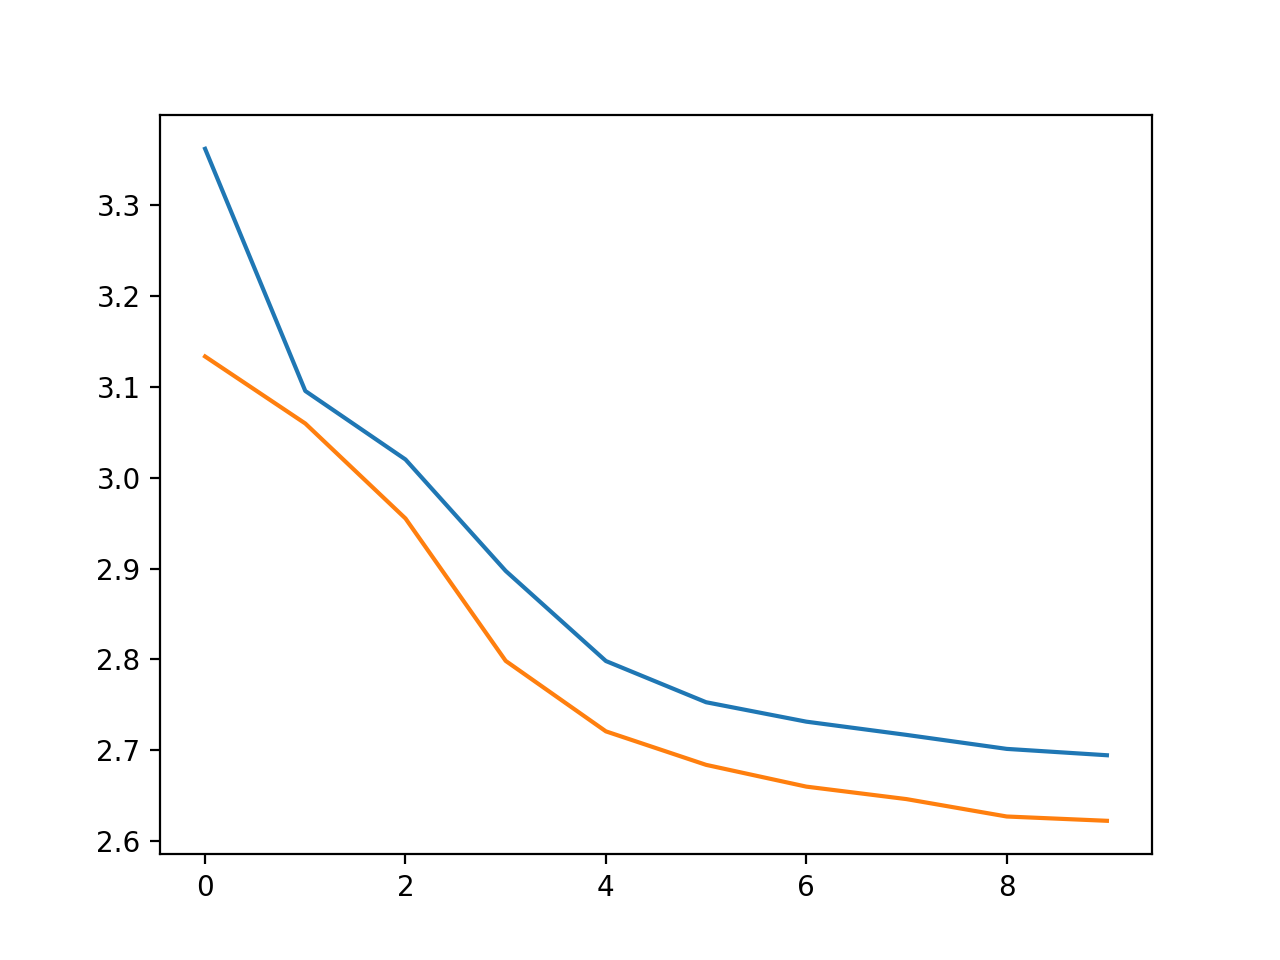

In [232]:
plt.plot(my_model.history['loss'])
plt.plot(my_model.history['val_loss'])


In [235]:
def generate_name(model, location, variability=0.6):
    loc_features = np.array([to_normalized_polar_coords(location[0], location[1])])
    previous_chars = X[NAME_INPUT_NAME][0, :, :][np.newaxis, :, :]
    result = "".join([one_hot_to_char(oh) for oh in previous_chars[0]])
    
    for char_idx in range(NAME_DIMENSION):
        y = model.predict({NAME_INPUT_NAME: previous_chars, LOCATION_INPUT_NAME: loc_features})
        new_char = single_softmax_to_char(y, variability=variability)
        if new_char == NAME_END_CHAR:
            break
        result += new_char
        new_char_one_hot = ONE_HOT_MAP[new_char][np.newaxis, :]
        previous_chars = np.append(previous_chars[0][1:], new_char_one_hot, axis=0)[np.newaxis, :, :]

    return result.strip('>')

In [236]:
sorted([generate_name(model, [52.46831035320877, 13.42983903214842]) for i in range(20)])

['alla',
 'bare',
 'bgan',
 'chari',
 'corile',
 'eid',
 'lera',
 'nin',
 'pore',
 'san erchint',
 'sancerka',
 'sangeina',
 'saw derkosan ser',
 'ser araste lo cala',
 'shelite',
 'son',
 'tanay',
 'tat maraa',
 'til',
 'wury']